# Aprendizaje Automático I - Trabajo Práctico N°2

- Antuña, Franco (A-4637/1)
- Asad, Gonzalo (A-4595/1)
- Castells, Sergio (C-7334/2)

## Descripción del dataset

El dataset contiene información climática de Australia de los últimos años, incluyendo si para el día siguiente llovió o no en la columna 'RainTomorrow'. El contenido de cada columna se describe a continuación:

* Date: La fecha de la observación en formato YYYY-MM-DD.
* Location: La ciudad o estación meteorológica donde se realizó la observación.
* MinTemp: La temperatura mínima registrada en grados Celsius.
* MaxTemp: La temperatura máxima registrada en grados Celsius.
* Rainfall: La cantidad de lluvia registrada en milímetros.
* Evaporation: La cantidad de agua evaporada (en milímetros) en 24 horas hasta las 9 AM.
* Sunshine: El número de horas de sol registrado.
* WindGustDir: La dirección del viento más fuerte registrado durante el día.
* WindGustSpeed: La velocidad del viento más fuerte registrado en kilómetros por hora.
* WindDir9am: La dirección del viento a las 9 AM.
* WindDir3pm: La dirección del viento a las 3 PM.
* WindSpeed9am: La velocidad del viento a las 9 AM en kilómetros por hora.
* WindSpeed3pm: La velocidad del viento a las 3 PM en kilómetros por hora.
* Humidity9am: La humedad relativa a las 9 AM como porcentaje.
* Humidity3pm: La humedad relativa a las 3 PM como porcentaje.
* Pressure9am: La presión atmosférica a las 9 AM medida en hPa (hectopascales).
* Pressure3pm: La presión atmosférica a las 3 PM medida en hPa.
* Cloud9am: La fracción del cielo cubierto de nubes a las 9 AM (medido en octas: una escala de 0 a 8).
* Cloud3pm: La fracción del cielo cubierto de nubes a las 3 PM (medido en octas).
* Temp9am: La temperatura registrada a las 9 AM en grados Celsius.
* Temp3pm: La temperatura registrada a las 3 PM en grados Celsius.
* RainToday: Un valor binario (Yes/No) que indica si llovió o no en las últimas 24 horas.
* RainTomorrow: Un valor binario (Yes/No) que indica si llovió o no al día siguiente (esta es la variable objetivo para modelos predictivos).

Fuente: https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package

## Preparación del entorno

In [1]:
!pip install gdown

In [2]:
import gdown
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, auc
from imblearn.over_sampling import RandomOverSampler, SMOTE

In [3]:
# Definir el ID del archivo
file_id = '1gH6RH6Xya2-KK089FgSOaCd6RESLWbOe'

# Crear la URL de descarga
download_url = f'https://drive.google.com/uc?id={file_id}'

# Descargar el archivo
output = 'weatherAUS.csv'
gdown.download(download_url, output, quiet=True)

'weatherAUS.csv'

In [4]:
df = pd.read_csv('weatherAUS.csv')

Elegimos 10 ciudades al azar para usar durante todo el trabajo práctico.

In [5]:
# Selecciono 10 ciudades aleatorias de la columna 'Location'
ciudades_aleatorias = df['Location'].drop_duplicates().sample(n=10, random_state=42)
# Muestro las ciudades seleccionadas
print(ciudades_aleatorias)
# Filtro el DataFrame original usando las 10 ciudades seleccionadas
df_filtrado = df[df['Location'].isin(ciudades_aleatorias)].reset_index()

39538      Williamtown
136071    AliceSprings
142304       Katherine
133031      Launceston
52062      MountGinini
80998         Dartmoor
77989         Watsonia
74980         Portland
93280       Townsville
58142          Bendigo
Name: Location, dtype: object


Eliminamos todas las filas donde la variable 'RainTomorrow' tiene valor NaN, ya que pierde el sentido tenerlas si vamos a hacer un modelo que las prediga.

In [6]:
index_NaN = df_filtrado[df_filtrado['RainTomorrow'].isna()].index
df_filtrado.drop(index_NaN, inplace=True)
df_filtrado.reset_index(drop=True, inplace=True)

Hacemos la separación del dataset entre la variable de salida 'RainTomorrow' y el resto de los datos. A estos últimos los separamos entre datasets de entrenamiento y de pruebas.

In [7]:
# Dividimos el dataset en datos de entrenamiento y de testeo
X = df_filtrado.drop('RainTomorrow', axis=1)
y = df_filtrado['RainTomorrow']

# Creamos datasets de entrenamiento y de pruebas
X_train, X_test, y_train, y_test = train_test_split(X, y.values.reshape(-1,1), test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((22466, 23), (5617, 23), (22466, 1), (5617, 1))

## Análisis descriptivo

Observamos rápidamente el contenido del dataset de entrenamiento.

In [8]:
train_data = X_train.reset_index(drop=True)
train_data = pd.concat([train_data.drop('index', axis=1), pd.DataFrame(y_train, columns=['RainTomorrow'])], axis=1)
train_data.head()

Date     Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0  2010-12-01     Watsonia     15.4     26.3       0.0          5.4       0.6   
1  2008-12-30  MountGinini      5.0     10.0       0.0          NaN       NaN   
2  2012-09-16     Dartmoor      8.8     15.1       0.4          0.8       1.0   
3  2010-02-15     Dartmoor     16.1     25.2       0.4          1.6       7.8   
4  2012-05-15     Dartmoor      8.8     14.9       1.4          1.2       0.6   

  WindGustDir  WindGustSpeed WindDir9am  ... Humidity9am  Humidity3pm  \
0          SE           30.0          W  ...        87.0         68.0   
1         NaN            NaN          W  ...        65.0        100.0   
2         WSW           37.0         NW  ...       100.0         78.0   
3         ESE           44.0        SSE  ...        87.0         65.0   
4           S           22.0        NaN  ...       100.0         82.0   

   Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  \
0       1016.0       1013.3       7.0       7.0     18.0     22.9         No   
1          NaN          NaN       NaN       NaN      8.4      5.5         No   
2       1021.1       1019.5       NaN       NaN     11.6     13.9         No   
3       1015.7       1016.0       NaN       NaN     18.8     23.5         No   
4       1030.8       1028.3       NaN       NaN     10.8     14.2        Yes   

   RainTomorrow  
0           Yes  
1           Yes  
2            No  
3            No  
4            No  

[5 rows x 23 columns]

Estudiamos el tipo de los datos.

In [9]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22466 entries, 0 to 22465
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           22466 non-null  object 
 1   Location       22466 non-null  object 
 2   MinTemp        22358 non-null  float64
 3   MaxTemp        22432 non-null  float64
 4   Rainfall       22195 non-null  float64
 5   Evaporation    14826 non-null  float64
 6   Sunshine       11635 non-null  float64
 7   WindGustDir    22048 non-null  object 
 8   WindGustSpeed  22050 non-null  float64
 9   WindDir9am     20765 non-null  object 
 10  WindDir3pm     22153 non-null  object 
 11  WindSpeed9am   22294 non-null  float64
 12  WindSpeed3pm   22307 non-null  float64
 13  Humidity9am    21900 non-null  float64
 14  Humidity3pm    21440 non-null  float64
 15  Pressure9am    19215 non-null  float64
 16  Pressure3pm    19214 non-null  float64
 17  Cloud9am       14128 non-null  float64
 18  Cloud3

Vemos que la mayoría de las variables son del tipo 'float64' a excepción de 'Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDit3pm', 'RainToday' y 'RainTomorrow', que son del tipo 'object'. Luego analizamos la existencia de datos duplicados.

In [10]:
train_data.duplicated().sum()

0

No existen datos duplicados en el dataset.

Observamos las características descriptivas del dataset.

In [11]:
train_data.describe(include='all')

Date    Location       MinTemp       MaxTemp      Rainfall  \
count        22466       22466  22358.000000  22432.000000  22195.000000   
unique        3040          10           NaN           NaN           NaN   
top     2015-08-19  Townsville           NaN           NaN           NaN   
freq            10        2464           NaN           NaN           NaN   
mean           NaN         NaN     11.136976     22.308791      2.370390   
std            NaN         NaN      7.130376      8.464360      8.432189   
min            NaN         NaN     -8.200000     -4.800000      0.000000   
25%            NaN         NaN      6.100000     15.800000      0.000000   
50%            NaN         NaN     10.400000     21.500000      0.000000   
75%            NaN         NaN     15.800000     28.900000      0.800000   
max            NaN         NaN     30.300000     45.500000    236.800000   

         Evaporation      Sunshine WindGustDir  WindGustSpeed WindDir9am  ...  \
count   14826.000000  11635.000000       22048   22050.000000      20765  ...   
unique           NaN           NaN          16            NaN         16  ...   
top              NaN           NaN          NW            NaN         SE  ...   
freq             NaN           NaN        1691            NaN       1767  ...   
mean        5.778302      7.400791         NaN      39.852880        NaN  ...   
std         4.505051      3.904221         NaN      13.066766        NaN  ...   
min         0.000000      0.000000         NaN       7.000000        NaN  ...   
25%         2.600000      4.300000         NaN      31.000000        NaN  ...   
50%         5.200000      8.200000         NaN      39.000000        NaN  ...   
75%         8.000000     10.600000         NaN      46.000000        NaN  ...   
max       145.000000     14.300000         NaN     135.000000        NaN  ...   

         Humidity9am   Humidity3pm   Pressure9am   Pressure3pm      Cloud9am  \
count   21900.000000  21440.000000  19215.000000  19214.000000  14128.000000   
unique           NaN           NaN           NaN           NaN           NaN   
top              NaN           NaN           NaN           NaN           NaN   
freq             NaN           NaN           NaN           NaN           NaN   
mean       70.873516     54.038153   1016.985803   1014.563188      4.518049   
std        21.599808     22.324861      7.222081      7.303454      2.942374   
min         1.000000      1.000000    985.000000    980.200000      0.000000   
25%        59.000000     39.000000   1012.200000   1009.600000      1.000000   
50%        73.000000     55.000000   1017.000000   1014.500000      5.000000   
75%        89.000000     69.000000   1021.700000   1019.500000      7.000000   
max       100.000000    100.000000   1040.500000   1039.600000      8.000000   

            Cloud3pm       Temp9am       Temp3pm  RainToday  RainTomorrow  
count   13482.000000  22085.000000  21683.000000      22195         22466  
unique           NaN           NaN           NaN          2             2  
top              NaN           NaN           NaN         No            No  
freq             NaN           NaN           NaN      17080         17218  
mean        4.611556     16.065216     20.630715        NaN           NaN  
std         2.763651      7.719187      8.163236        NaN           NaN  
min         0.000000     -7.200000     -5.400000        NaN           NaN  
25%         2.000000     10.600000     14.500000        NaN           NaN  
50%         5.000000     15.000000     19.800000        NaN           NaN  
75%         7.000000     21.700000     26.700000        NaN           NaN  
max         8.000000     39.100000     43.900000        NaN           NaN  

[11 rows x 23 columns]

A simple vista, se detectan cosas extrañas como la variable 'Rainfall', donde el Q3 = 0.8, mientras que su variable máxima es 236.8 dando a entender que tiene un sesgo. Algo similar al caso anterior ocurre con la variable 'Evaporation'. Vemos que en todas las variables numéricas, su media se encuentra bastante cercana a su mediana, haciendo parecer que se encuentran bastante balanceadas.
Estas hipótesis serán comprobadas más adelante, durante el análisis visual exploratorio.

## Análisis exploratorio

Filtramos las variables del tipo Object.

In [12]:
non_categoric_cols = train_data.select_dtypes(exclude='object').columns

Para evitar mensajes asociados a cambios planeados en futuras versiones de las librerías en uso, hacemos uso de la función 'filterwarnings'.

In [13]:
warnings.filterwarnings('ignore', category=FutureWarning)

Graficamos los diagramas de caja y bigotes junto con los histogramas de cada variable numérica.

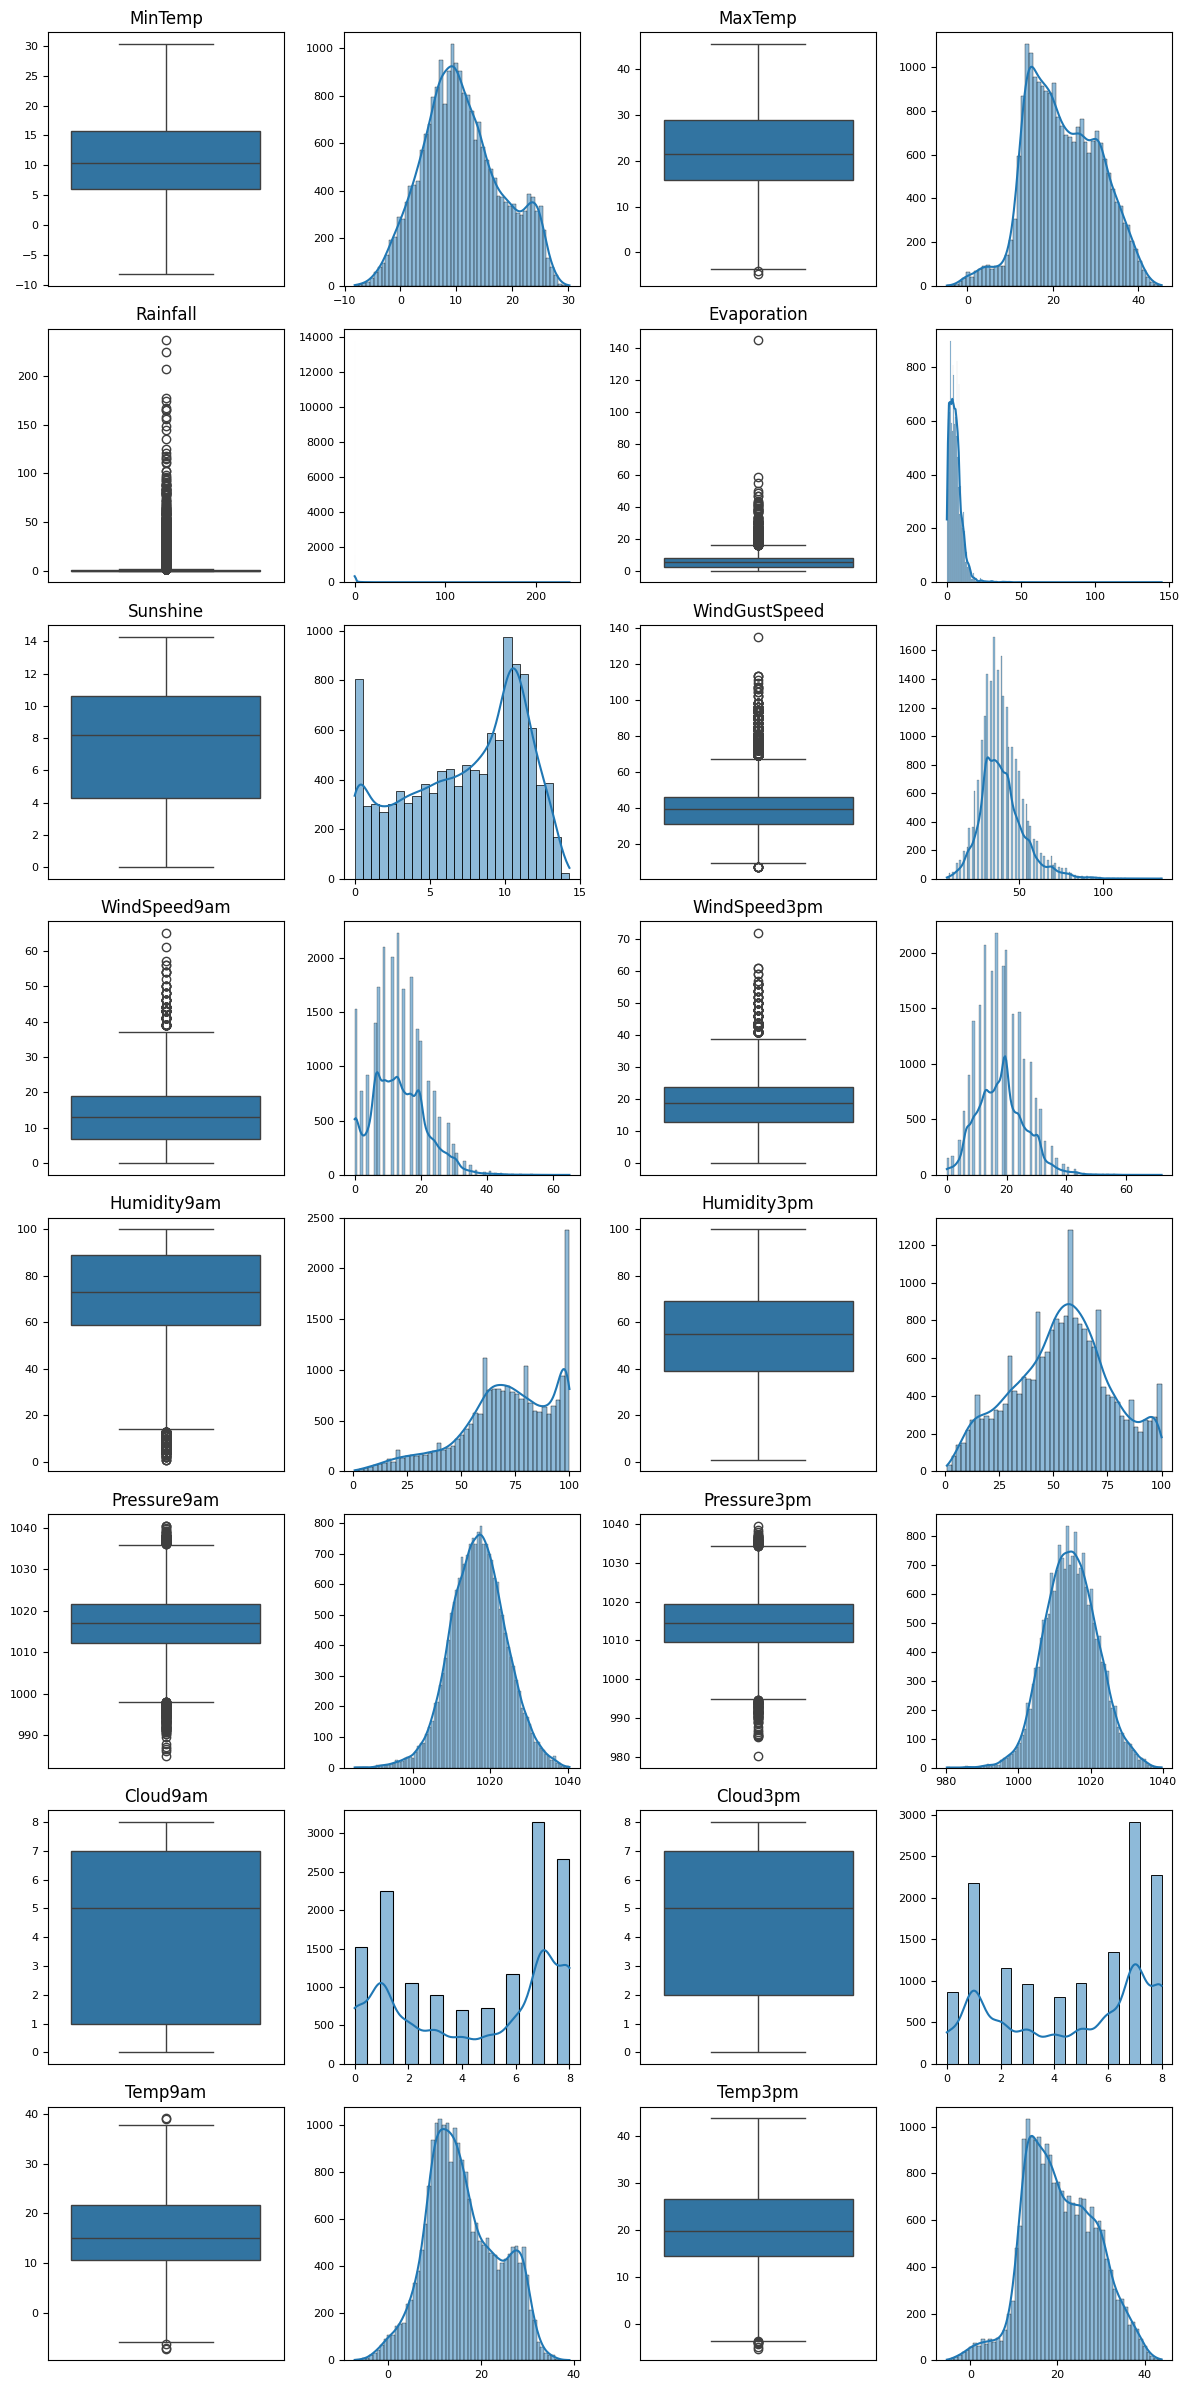

In [14]:
# Crear diagrama de caja individual para cada variable
plt.figure(figsize=(12, 24))
idx = 0
for column in non_categoric_cols:
    # Boxplot
    plt.subplot(8, 4, idx+1)
    sns.boxplot(data = train_data[column])
    plt.title(column)
    plt.ylabel('')
    plt.xticks([])
    plt.yticks(fontsize=8)

    # Distplot
    plt.subplot(8, 4, idx+2)
    sns.histplot(data=train_data, x=column, kde=True)
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)

    idx += 2

plt.tight_layout()
plt.show()

Observamos que hay muchos comportamientos diferentes entre las variables:
*   Las variables "Pressure9am" y "Pressure3pm" poseen una distribución bastante simétrica.Tienen una forma campanular aunque con la información provista arriba no podemos asegurar que su distribución sea normal.
*   Las variables "Temp9am", "Temp3pm", "MaxTemp", "MinTemp", "Rainfall", "Evaporation", "WindGustSpeed", "WindSpeed9am" y "WindSpeed3pm" tienen distribuciones con diferentes sesgos hacia la izquierda o derecha. Casos a destacar son las variables 'Rainfall' y 'Evaporation', donde sus sesgos son mucho más fuertes que en el resto de las variables.
*   El resto de las variables poseen más de una moda, como ocurre con las variables 'Sunshine', 'Cloud9am' y 'Cloud3pm'.

Hay presencia de outliers en la mayoría de las variables, pero en la mayoría de los casos parece desprenderse del comportamiento natural del clima.

Graficamos las dispersiones entre todos los pares de variables numéricas.

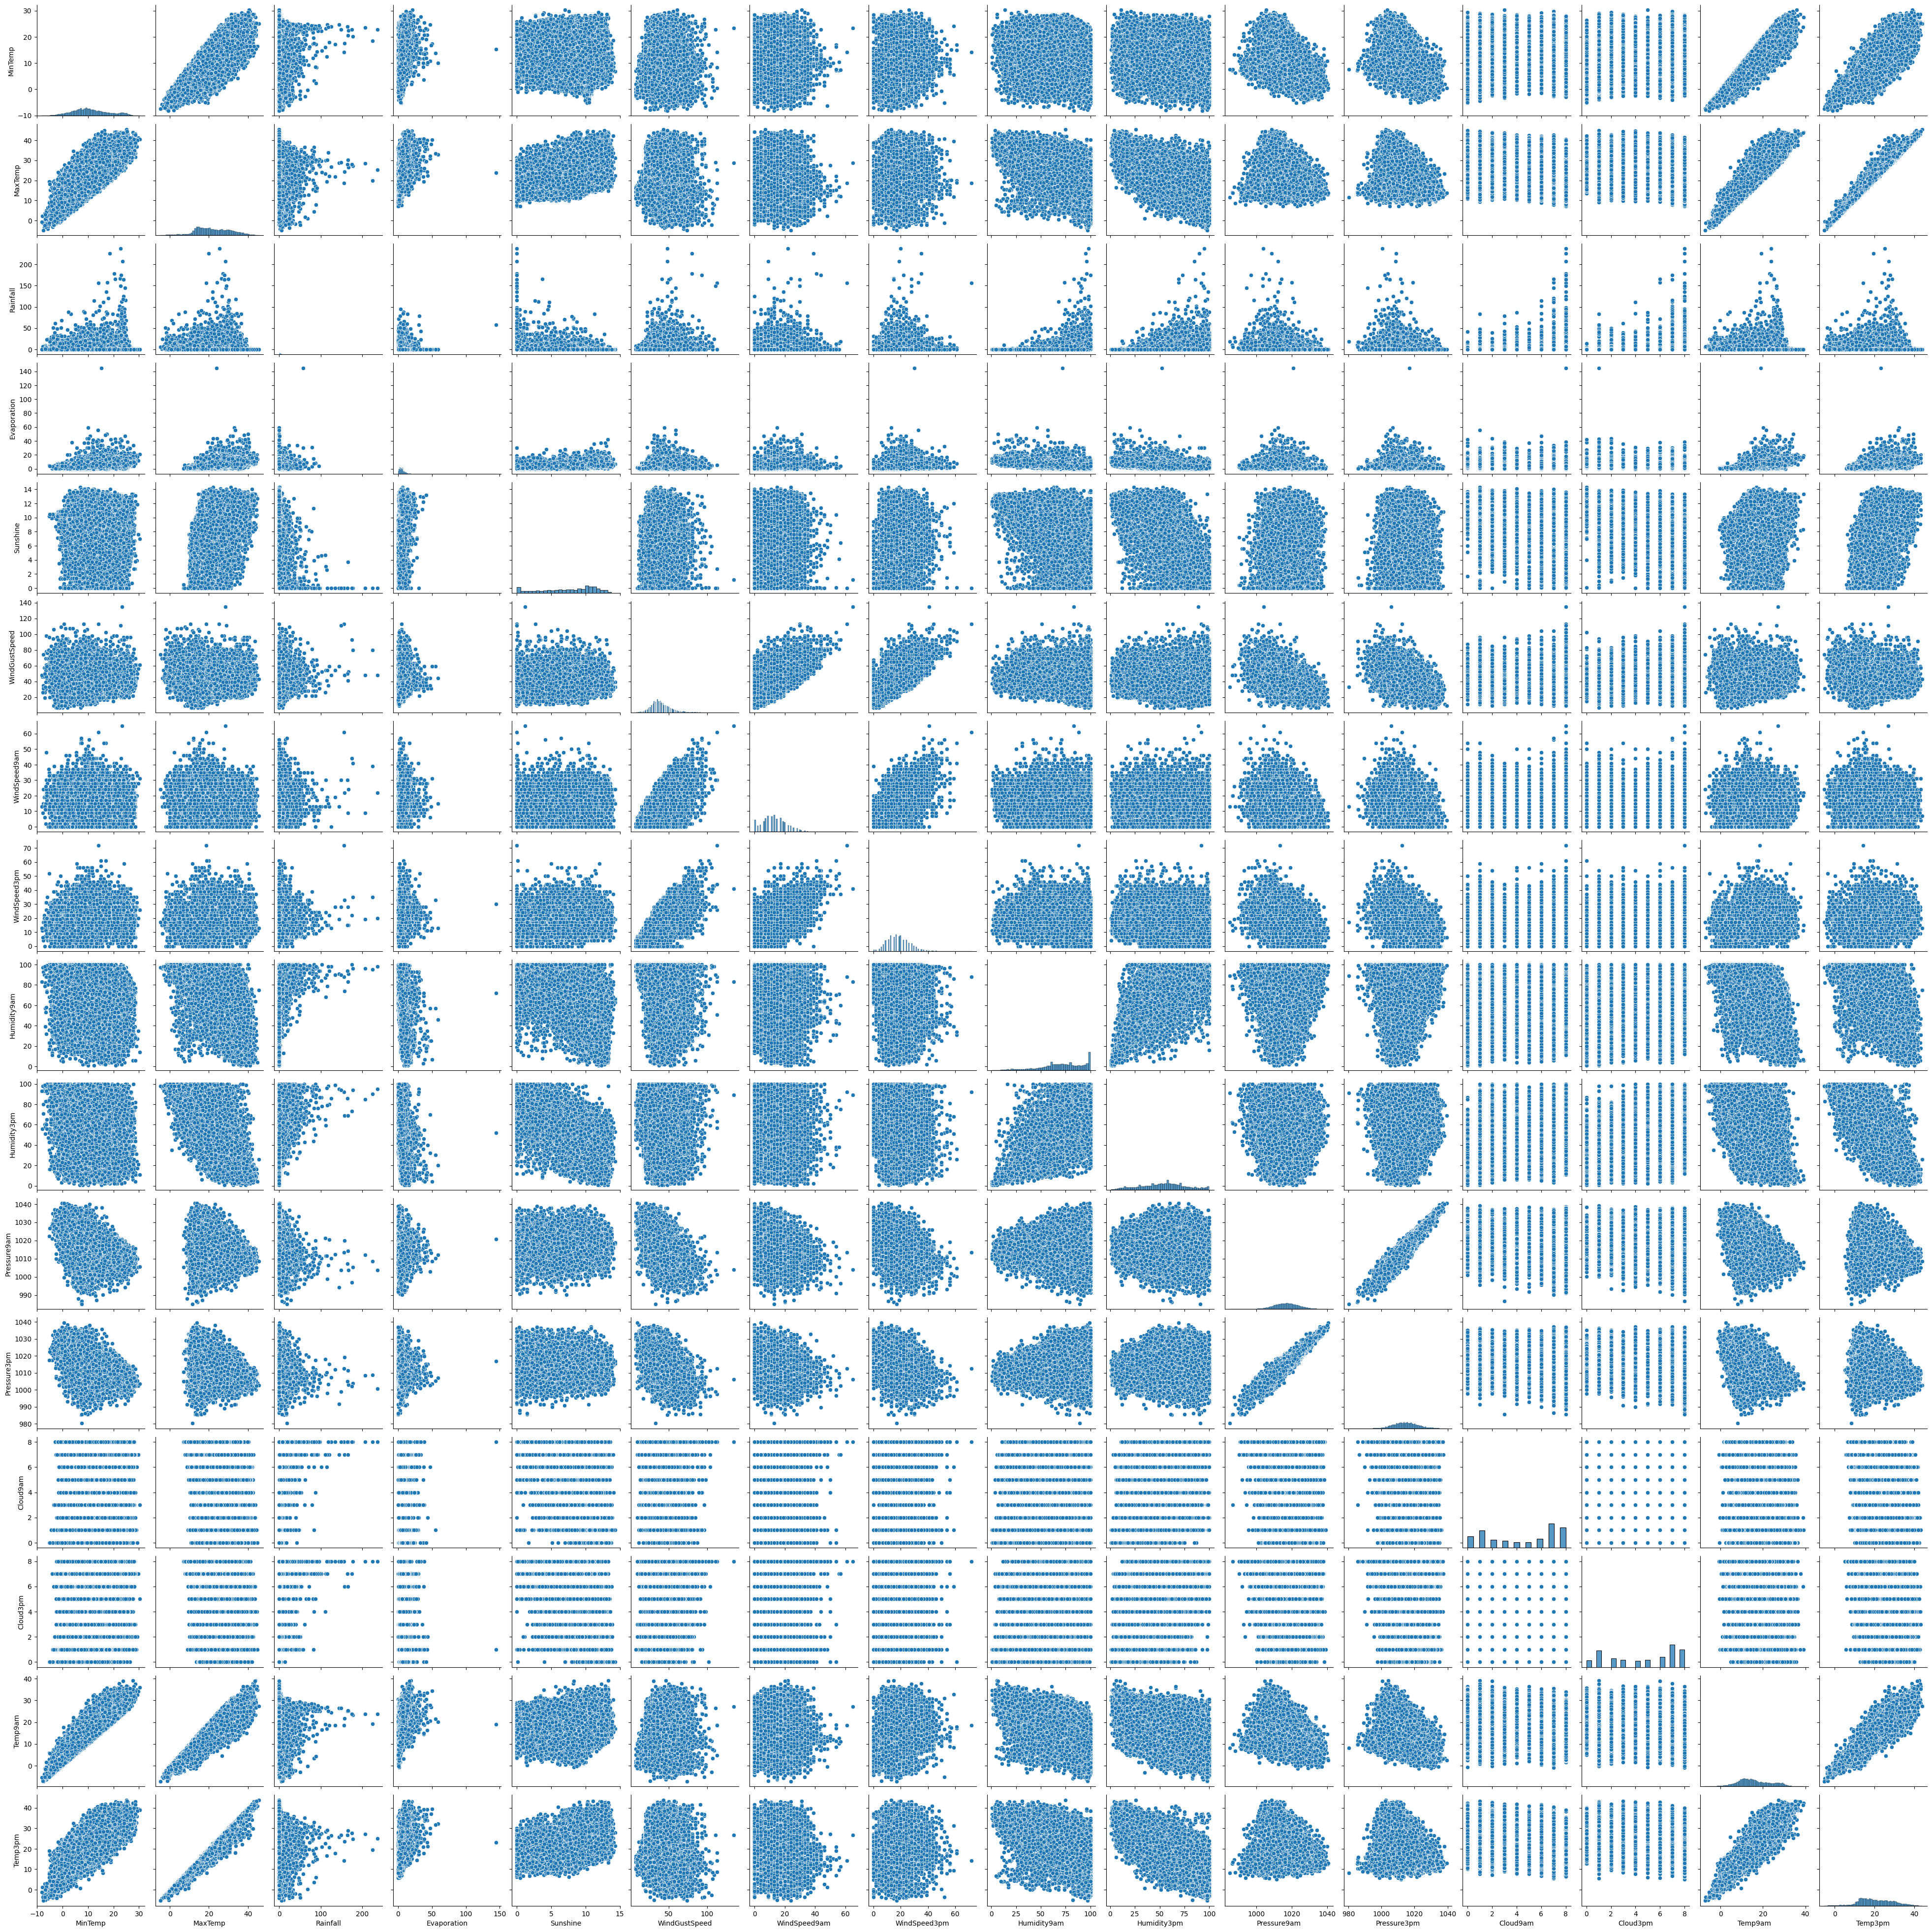

In [15]:
sns.pairplot(train_data[non_categoric_cols])
plt.show()

Observando rápidamente las dispersiones entre pares de variables, a simple vista se pueden detectar varias que podrían ser lineales. Sin embargo, la mayoría de las mismas tienen comportamientos más parecidos a una "nube de puntos".

Calculamos la matriz de correlación de las variables y la graficamos en un mapa de calor.

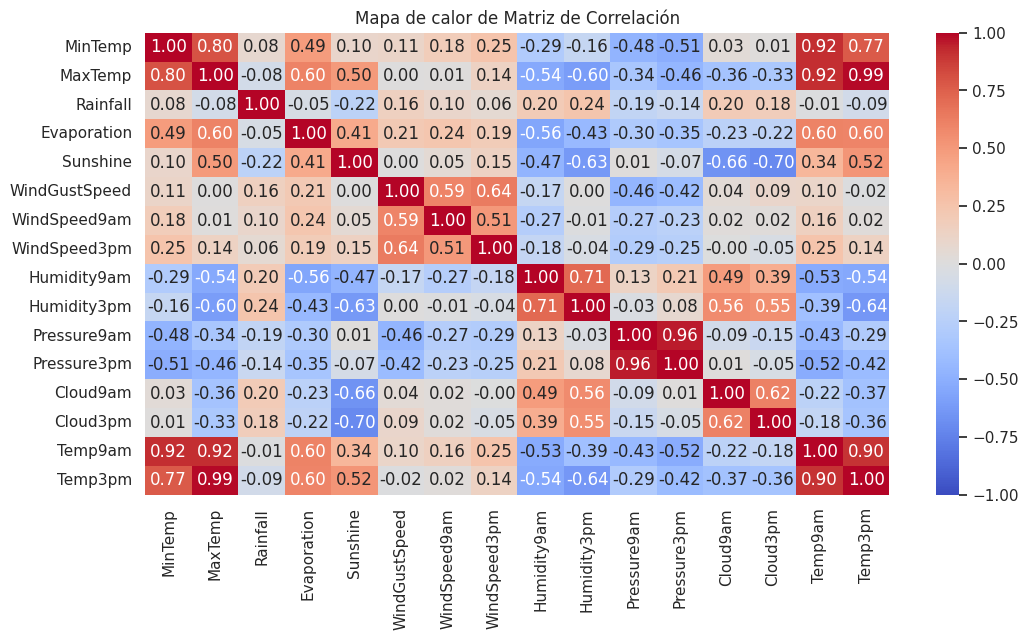

In [16]:
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.heatmap(train_data[non_categoric_cols].corr(method = 'pearson'), annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Mapa de calor de Matriz de Correlación')
plt.show()

Observamos muchas correlaciones lineales fuertes, entre las que se destacan:
*   'MaxTemp' con 'Temp3pm' y con 'Temp9am' directamente
*   'MinTemp' con 'Temp9am' directamente
*   'Pressure9am' con 'Pressure3pm' directamente
*   'MinTemp' con 'MaxTemp' directamente
*   'Sunshine' con 'Cloud3pm' y 'Cloud9am' inversamente

Todas las correlaciones son previsibles, de un comportamiento que nos resulta natural entender.

## Limpieza, imputación y escalado

Categorizamos las variables tipo Object a excepción de 'Date' en los datasets de entrenamiento y de pruebas.

In [17]:
# Buscamos columnas tipo object
categoric_cols = train_data.select_dtypes(exclude='float64').columns.drop(['RainTomorrow','Date'])

# Categorizamos columnas
X_train[categoric_cols] = X_train[categoric_cols].astype('category')
X_test[categoric_cols] = X_test[categoric_cols].astype('category')

Convertimos la columna Date a tipo datetime.

In [18]:
# Convertimos la columna 'Date' a tipo datetime
X_train['Date'] = pd.to_datetime(X_train['Date'])
X_test['Date'] = pd.to_datetime(X_test['Date'])

En base a las observaciones sobre los boxplots, elegimos eliminar tres datos que consideramos outliers. No deberán afectar significativamente a las predicciones por ser menos del 0,1% de la totalidad de los datos y nos asegurará una mejor imputación y escalado.

In [19]:
indexes = []

indexes.append(X_train[X_train['Evaporation'] > 130.0].index[0])
indexes.append(X_train[X_train['WindGustSpeed'] > 120.0].index[0])
indexes.append(X_train[X_train['WindSpeed3pm'] > 70].index[0])

X_train.drop(indexes, inplace=True)
y_train = np.delete(y_train, indexes)

Contabilizamos los datos nulos.

In [20]:
train_data.isna().sum()

Date                 0
Location             0
MinTemp            108
MaxTemp             34
Rainfall           271
Evaporation       7640
Sunshine         10831
WindGustDir        418
WindGustSpeed      416
WindDir9am        1701
WindDir3pm         313
WindSpeed9am       172
WindSpeed3pm       159
Humidity9am        566
Humidity3pm       1026
Pressure9am       3251
Pressure3pm       3252
Cloud9am          8338
Cloud3pm          8984
Temp9am            381
Temp3pm            783
RainToday          271
RainTomorrow         0
dtype: int64

La variable 'Date' es del tipo 'Timestamp' que no es admitido a la hora de imputar o entrenar el modelo. Es por eso que su información se descompone en dos nuevas variables 'Year' y 'Month' con el año y el mes respectivamente, que consideramos ser las variables más significativas de la fecha.

In [21]:
X_train_modified = X_train.copy()
X_test_modified = X_test.copy()

# Descomponer la columna "Date"
X_train_modified['Year'] = X_train_modified['Date'].dt.year
X_train_modified['Month'] = X_train_modified['Date'].dt.month
X_test_modified['Year'] = X_test_modified['Date'].dt.year
X_test_modified['Month'] = X_test_modified['Date'].dt.month

# Eliminar la columna "Date"
X_train_modified = X_train_modified.drop('Date', axis=1)
X_test_modified = X_test_modified.drop('Date', axis=1)

Codificamos el resto de las variables tipo object o category para poder así utilizarlos durante la imputación y el entrenamiento del modelo. Los datos faltantes (NaN) se mantienen como tales.

**Codificacion de la variable "Location"** --> Se Codifica en función de los valores de Latitud y Longitud

Justificación:

Codificar la variable categórica "Location" usando las coordenadas de latitud y longitud puede ser un buen enfoque, dependiendo del contexto del problema.

Cuándo es un buen criterio:

1) Modelos que dependen de la ubicación geográfica: Si la ubicación geográfica de la ciudad es relevante para el problema
(por ejemplo, en modelos relacionados con clima, geografía, logística o transporte), las coordenadas de latitud y longitud
pueden capturar mejor la relación entre la ubicación y el objetivo del modelo.

Ejemplo: Si se está construyendo un modelo que predice el clima, la cercanía geográfica a la costa, la altitud o la posición relativa pueden ser importantes.

Ventajas:

* La codificación de latitud y longitud permite que el modelo capture distancias geográficas entre las ciudades, algo que no se podría lograr fácilmente con otras codificaciones como One-Hot Encoding.

* Reducción de la dimensionalidad: Codificar ciudades con latitud y longitud reduce significativamente el número de columnas en comparación con One-Hot Encoding, que crearía una columna para cada ciudad. Si se tienen muchas ciudades, esta técnica es más eficiente y compacta.

2) Modelos que pueden beneficiarse de las relaciones espaciales: Modelos como los k-Nearest Neighbors (k-NN) o incluso modelos de redes neuronales pueden beneficiarse de la codificación por coordenadas, ya que podrían aprender a agrupar o clasificar basándose en proximidad geográfica.

In [22]:
# CODIFICACIÓN DE LA VARIABLE "Location" --> Se Codifica en función de los valores de Latitud y Longitud

# Creo el diccionario con las coordenadas (latitud, longitud)
location_coordinates = {
    'Williamtown': (-32.7925, 151.8397),
    'AliceSprings': (-23.6980, 133.8807),
    'Katherine': (-14.4657, 132.2635),
    'Launceston': (-41.4332, 147.1441),
    'MountGinini': (-35.5292, 148.7722),
    'Dartmoor': (-38.0667, 141.2167),
    'Watsonia': (-37.7161, 145.0831),
    'Portland': (-38.3496, 141.5881),
    'Townsville': (-19.2564, 146.8186),
    'Bendigo': (-36.7570, 144.2794),
}

# Creo las columnas 'Latitude' y 'Longitude' en los datasets de entrenamiento y testeo
X_train_modified['Latitude'] = X_train_modified['Location'].map(lambda x: location_coordinates[x][0] if x in location_coordinates else np.nan)
X_train_modified['Longitude'] = X_train_modified['Location'].map(lambda x: location_coordinates[x][1] if x in location_coordinates else np.nan)

X_test_modified['Latitude'] = X_train_modified['Location'].map(lambda x: location_coordinates[x][0] if x in location_coordinates else np.nan)
X_test_modified['Longitude'] = X_train_modified['Location'].map(lambda x: location_coordinates[x][1] if x in location_coordinates else np.nan)

# Elimino la columna "Location"
X_train_modified.drop('Location', axis=1, inplace=True)
X_test_modified.drop('Location', axis=1, inplace=True)

**Codificación de la variable "Month"** --> Se Codifica usando la técnica seno-coseno

La técnica de codificación seno-coseno es un método que se utiliza para representar variables categóricas o cíclicas de manera que se preserve su naturaleza cíclica. Esta técnica es particularmente útil para variables que tienen una periodicidad natural, como:

* Mes del año (donde enero y diciembre están cerca)
* Hora del día (donde la medianoche y las 23:59 están cerca)
* Día de la semana (donde domingo y lunes están cerca)

Cuando se tiene una variable cíclica (por ejemplo, las horas del día), los valores más altos y más bajos están muy cerca uno del otro en la realidad, pero si esos valores se codifican como enteros regulares, el modelo puede interpretar erróneamente que los valores altos están muy lejos de los bajos.

Por ejemplo: Hora del día: Si se codifica las 23 horas como un valor entero, el valor 23 parecería mucho mayor que el valor 0 (medianoche), aunque en realidad están a solo una hora de distancia.

Para resolver este problema, se puede usar la codificación seno-coseno, que transforma las variables cíclicas en coordenadas circulares. Esto hace que la relación de cercanía entre los extremos de la variable quede preservada.

Siempre que se use codificación seno-coseno para representar una variable cíclica, se necesitará generar dos columnas por variable:
una para el seno y otra para el coseno. Esto se debe a que se está representando la variable en un espacio bidimensional que captura
tanto la posición en el ciclo (mediante el seno) como la dirección (mediante el coseno).

La combinación de las dos columnas (seno y coseno) permite capturar completamente la naturaleza cíclica de la variable:

* Seno representa la variación vertical en un círculo. Cuando el valor es alto, se encuentra en la parte superior del círculo, y cuando es bajo, se encuentra en la parte inferior.
* Coseno representa la variación horizontal en un círculo. Cuando el valor es alto, se encuentra en la parte derecha del círculo, y cuando es bajo, se encuentra en la parte izquierda.

Juntos, seno y coseno describen una posición en el ciclo de manera completa y continua. Si solo se usara una de las dos funciones, se perdería parte de la información y no se capturaría adecuadamente la relación cíclica entre los valores.

In [23]:
# CODIFICACIÓN DE LA VARIABLE "Month" --> Se Codifica usando la técnica seno-coseno

# Creo las columnas 'Month_sin' y 'Month_con' en los datasets de entrenamiento y testeo
X_train_modified["Month_sin"] = np.where(pd.isna(X_train_modified["Month"]), np.NaN, np.sin(2 * np.pi * X_train_modified["Month"] / 12))
X_train_modified["Month_cos"] = np.where(pd.isna(X_train_modified["Month"]), np.NaN, np.cos(2 * np.pi * X_train_modified["Month"] / 12))

X_test_modified["Month_sin"] = np.where(pd.isna(X_test_modified["Month"]), np.NaN, np.sin(2 * np.pi * X_test_modified["Month"] / 12))
X_test_modified["Month_cos"] = np.where(pd.isna(X_test_modified["Month"]), np.NaN, np.cos(2 * np.pi * X_test_modified["Month"] / 12))

# Elimino la columna "Month"
X_train_modified.drop("Month", axis=1, inplace=True)
X_test_modified.drop("Month", axis=1, inplace=True)

In [24]:
# CODIFICACIÓN DE LAS VARIABLES  "WindGustDir", "WindDir9am", "WindDir3pm" --> Se Codifican usando la técnica seno-coseno

# Defino un diccionario con los ángulos correspondientes a cada dirección
wind_direction_angles = {
    'N': 0,
    'NNE': 22.5,
    'NE': 45,
    'ENE': 67.5,
    'E': 90,
    'ESE': 112.5,
    'SE': 135,
    'SSE': 157.5,
    'S': 180,
    'SSW': 202.5,
    'SW': 225,
    'WSW': 247.5,
    'W': 270,
    'WNW': 292.5,
    'NW': 315,
    'NNW': 337.5,
}

wind_direction_encoded = {}
for key, value in wind_direction_angles.items():
    wind_direction_encoded[key] = np.sin(np.deg2rad(value)), np.cos(np.deg2rad(value))


# Creo las columnas 'WindGustDir_sin' y 'WindGustDir_cos' en los datasets de entrenamiento y testeo
X_train_modified['WindGustDir_sin'] = X_train_modified['WindGustDir'].map(lambda x: wind_direction_encoded[x][0] if x in wind_direction_encoded else np.nan)
X_train_modified['WindGustDir_cos'] = X_train_modified['WindGustDir'].map(lambda x: wind_direction_encoded[x][1] if x in wind_direction_encoded else np.nan)

X_test_modified['WindGustDir_sin'] = X_test_modified['WindGustDir'].map(lambda x: wind_direction_encoded[x][0] if x in wind_direction_encoded else np.nan)
X_test_modified['WindGustDir_cos'] = X_test_modified['WindGustDir'].map(lambda x: wind_direction_encoded[x][1] if x in wind_direction_encoded else np.nan)

# Creo las columnas 'WindDir9am_sin' y 'WindDir9am_cos' en los datasets de entrenamiento y testeo
X_train_modified['WindDir9am_sin'] = X_train_modified['WindDir9am'].map(lambda x: wind_direction_encoded[x][0] if x in wind_direction_encoded else np.nan)
X_train_modified['WindDir9am_cos'] = X_train_modified['WindDir9am'].map(lambda x: wind_direction_encoded[x][1] if x in wind_direction_encoded else np.nan)

X_test_modified['WindDir9am_sin'] = X_test_modified['WindDir9am'].map(lambda x: wind_direction_encoded[x][0] if x in wind_direction_encoded else np.nan)
X_test_modified['WindDir9am_cos'] = X_test_modified['WindDir9am'].map(lambda x: wind_direction_encoded[x][1] if x in wind_direction_encoded else np.nan)

# Creo las columnas 'WindDir3pm_sin' y 'WindDir3pm_cos' en los datasets de entrenamiento y testeo
X_train_modified['WindDir3pm_sin'] = X_train_modified['WindDir3pm'].map(lambda x: wind_direction_encoded[x][0] if x in wind_direction_encoded else np.nan)
X_train_modified['WindDir3pm_cos'] = X_train_modified['WindDir3pm'].map(lambda x: wind_direction_encoded[x][1] if x in wind_direction_encoded else np.nan)

X_test_modified['WindDir3pm_sin'] = X_test_modified['WindDir3pm'].map(lambda x: wind_direction_encoded[x][0] if x in wind_direction_encoded else np.nan)
X_test_modified['WindDir3pm_cos'] = X_test_modified['WindDir3pm'].map(lambda x: wind_direction_encoded[x][1] if x in wind_direction_encoded else np.nan)

# Elimino las columnas "WindGustDir", "WindDir9am", "WindDir3pm"
X_train_modified.drop("WindGustDir", axis=1, inplace=True)
X_test_modified.drop("WindGustDir", axis=1, inplace=True)
X_train_modified.drop("WindDir9am", axis=1, inplace=True)
X_test_modified.drop("WindDir9am", axis=1, inplace=True)
X_train_modified.drop("WindDir3pm", axis=1, inplace=True)
X_test_modified.drop("WindDir3pm", axis=1, inplace=True)

In [25]:
# CODIFICACIÓN DE LA VARIABLE "RainToday"" --> Se implementa codificación binaria
X_train_modified['RainToday'] = X_train_modified['RainToday'].map({'Yes': 1, 'No': 0}, na_action='ignore')
X_test_modified['RainToday'] = X_test_modified['RainToday'].map({'Yes': 1, 'No': 0}, na_action='ignore')

In [26]:
# CODIFICACIÓN DE LA VARIABLE "Year"" --> Se implementa codificación One-Hot Encoding
# Esta codificación es adecuada en el caso de que cada año deba considerarse como una categoría distinta (es decir, no existe una relación secuencial clara entre ellos)

#Genero la codificación de los datasets de entrenamiento y testeo
X_train_modified = pd.get_dummies(X_train_modified, columns=['Year'], prefix='Year')
X_test_modified = pd.get_dummies(X_test_modified, columns=['Year'], prefix='Year')

Imputamos los datos faltantes de acuerdo al siguiente criterio:
* Si la variable posee una distribución simétrica, imputamos con la media
* Si la variable posee una distribución asimétrica, imputamos con la mediana
* Si la variable posee una distribución multimodal, imputamos con los k vecinos más cercanos
* Si la variable era categórica u objeto, imputamos con los k vecinos más cercanos

In [28]:
# Creamos los imputadores
imputador_media = SimpleImputer(strategy='mean')
imputador_mediana = SimpleImputer(strategy='median')
imputador_knn = KNNImputer()

# Lista de variables a imputar
lista_media = ["Pressure9am", "Pressure3pm"]
lista_mediana = ["Temp9am", "Temp3pm", "MaxTemp", "MinTemp", "Rainfall", "Evaporation", "WindGustSpeed", "WindSpeed9am", "WindSpeed3pm"]

# Copiamos datasets de entrenamiento
X_train_imputado = X_train_modified.copy()
X_test_imputado = X_test_modified.copy()

# Imputamos con la media
X_train_imputado[lista_media] = imputador_media.fit_transform(X_train_imputado[lista_media])
X_test_imputado[lista_media] = imputador_media.transform(X_test_imputado[lista_media])

# Imputamos con la mediana
X_train_imputado[lista_mediana] = imputador_mediana.fit_transform(X_train_imputado[lista_mediana])
X_test_imputado[lista_mediana] = imputador_mediana.transform(X_test_imputado[lista_mediana])

# Imputación kNN
X_train_imputado[X_train_modified.columns] = imputador_knn.fit_transform(X_train_imputado[X_train_modified.columns])
X_test_imputado[X_train_modified.columns] = imputador_knn.transform(X_test_imputado[X_train_modified.columns])

Comparación de las distribuciones de las variables antes y después de imputar

In [30]:
# Declaro una lista con las variables imputadas (columnas que contenían NaNs)
lista_imputadas = X_train_modified.columns[X_train_modified.isna().any()].tolist()


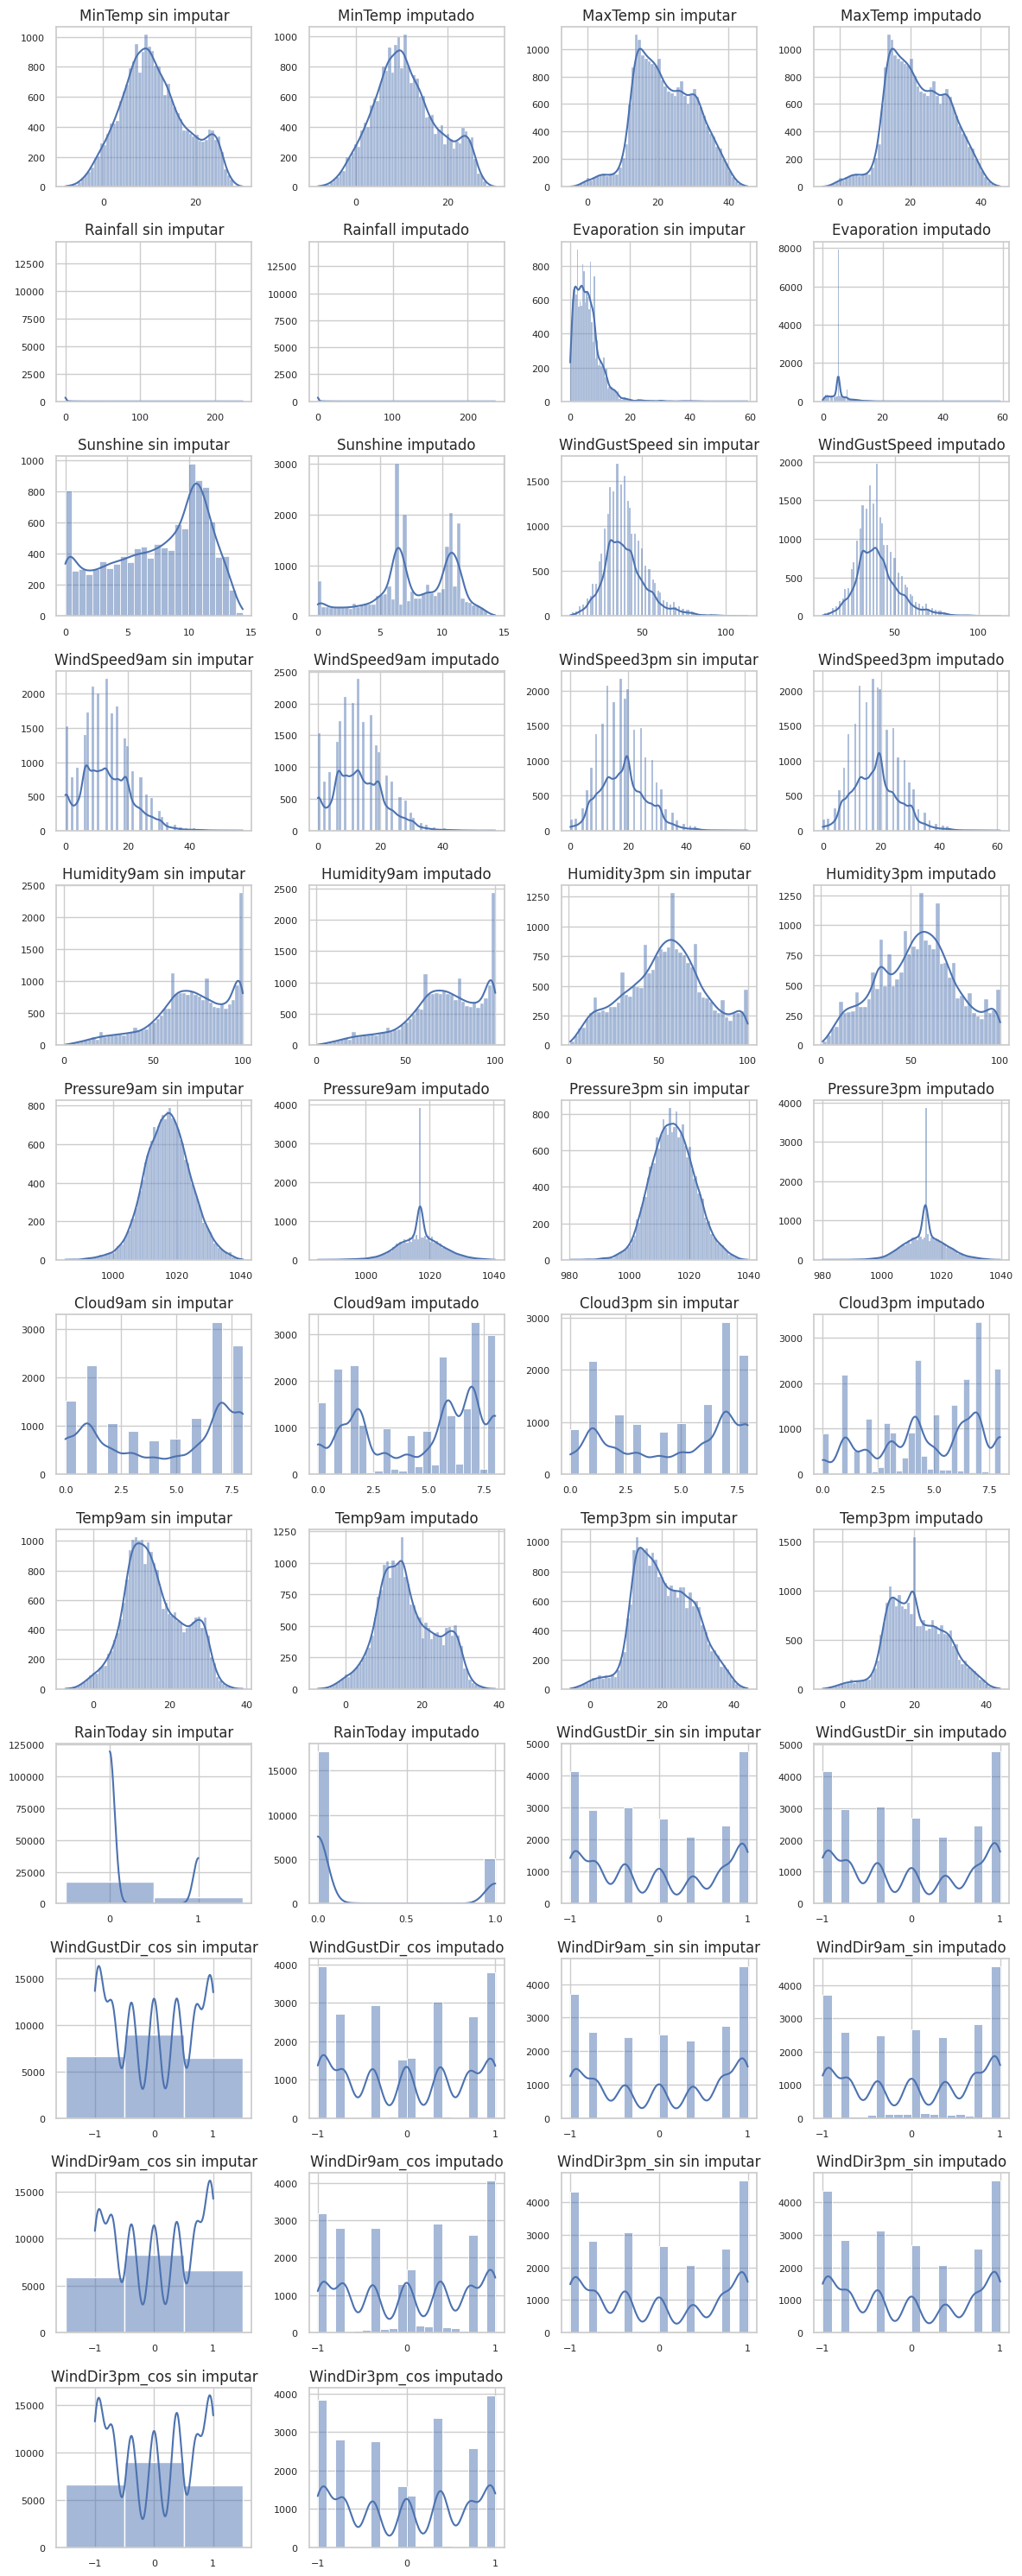

In [31]:
# Comparo las distribuciones de las variables antes y después de imputar
plt.figure(figsize=(12, 30))
idx = 0

# Variables Cuantitativas
#for column in non_categoric_cols:
for column in lista_imputadas:
    # Distplot
    plt.subplot(12, 4, idx+1)
    sns.histplot(data=X_train_modified, x=X_train_modified[column], kde=True)
    plt.title(f'{column} sin imputar')
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)

    # Distplot
    plt.subplot(12, 4, idx+2)
    sns.histplot(data=X_train_imputado, x=X_train_imputado[column], kde=True)
    plt.title(f'{column} imputado')
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)

    idx += 2

plt.tight_layout()
plt.show()

Escalamos los datos con un escalador robusto, ya que estamos incluyendo outliers en nuestro dataset final.

In [32]:
# Escalado de Variables

# Copiamos datasets de entrenamiento
X_train_escalado = X_train_imputado.copy()
X_test_escalado = X_test_imputado.copy()

# Instanciacion del escalador
scaler = RobustScaler()

# Escalado de variables
X_train_escalado = scaler.fit_transform(X_train_escalado)
X_test_escalado = scaler.transform(X_test_escalado)

Observamos la cantidad de días lluviosos y no lluviosos por ciudad para evaluar el balanceo.

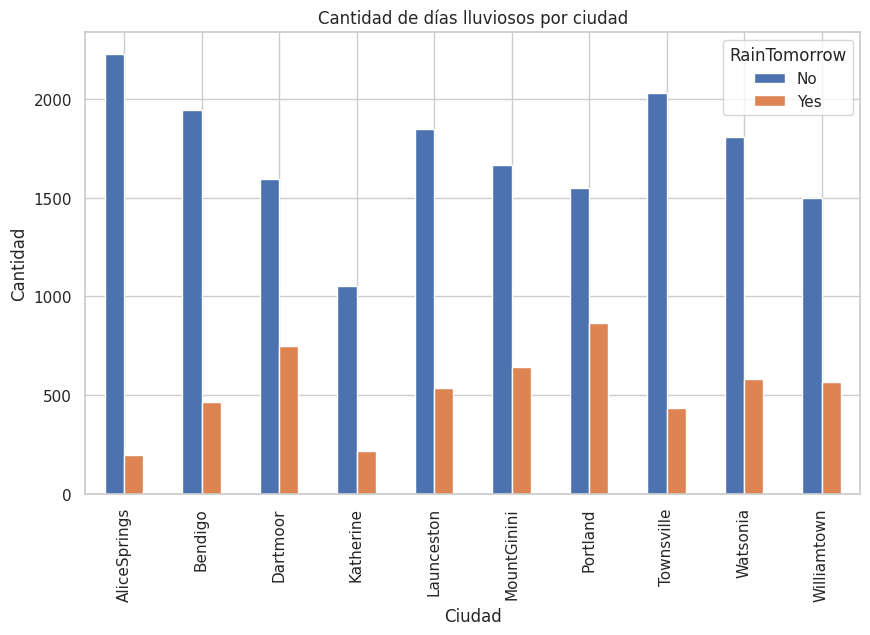

In [33]:
train_data.groupby(['Location', 'RainTomorrow']).size().unstack().plot(kind='bar', stacked=False, figsize=(10, 6))
plt.xlabel('Ciudad')
plt.ylabel('Cantidad')
plt.title('Cantidad de días lluviosos por ciudad')
plt.legend(title='RainTomorrow')
plt.show()

El dataset se encuentra bastante desbalanceado, donde la cantidad de días no lluviosos superan en gran cantidad a los días lluviosos en todas las ciudades. Es importante detectar si el dataset es balanceado o no, ya que determinará si se debe utilizar algún método de balanceo para evitar un sesgo en el modelo. Con el dataset actual, el modelo tendería a clasificar todos los días como días no lluviosos sin importar mucho el resto de los datos, simplemente por su frecuencia de aparición.

## Regresión Logística

Teniendo el dataset preparado, pasamos a entrenar un modelo de regresión logística con los datos de entrenamiento y probarlo con los datos de prueba.

In [34]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
# Inicializar y entrenar un modelo de regresión logística
model = LogisticRegression(random_state=42, max_iter=10000)
model.fit(X_train_escalado, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test_escalado)

# Calcular métricas
accuracy = accuracy_score(y_test, y_pred)

confusion_matrix = confusion_matrix(y_test, y_pred)

classification_report = classification_report(y_test, y_pred)

# Imprimir métricas
print("Métricas para logreg:")
print(f'Exactitud: {accuracy}')
print("Matriz de confusión:")
print(confusion_matrix)
print("Reporte de clasificación:")
print(classification_report)

Métricas para logreg:
Exactitud: 0.7689157913476945
Matriz de confusión:
[[4301    1]
 [1297   18]]
Reporte de clasificación:
              precision    recall  f1-score   support

          No       0.77      1.00      0.87      4302
         Yes       0.95      0.01      0.03      1315

    accuracy                           0.77      5617
   macro avg       0.86      0.51      0.45      5617
weighted avg       0.81      0.77      0.67      5617



Si bien la exactitud (accuracy) calculada con los resultados al usar los datos de prueba sería "moderada", es importante recordar que no se trata de una buena medida para usar en modelos desbalanceados como este. El modelo buscará clasificar la mayoría de los casos como días "no lluviosos" maximizando las probabilidades de acierto, pecando de un fuerte sesgo por el desbalance del dataset.

Si nos paramos en la métrica de precisión (precision), observamos que es muy alta para el caso de días lluviosos y moderada para los días no lluviosos. Este indicador habla de cuántos de los datos clasificados como posisitivos fueron realmente positivos. Viendo la matriz de confusión, vemos que el modelo clasificó 4300 verdaderos positivos y 1281 falsos positivos para la clase 'No', demostrando que al estar tan sesgado, clasifica erróneamente muchos datos que en realidad debieron ser 'Yes'. Esto no ocurre con la clase 'Yes', donde logra clasificar bien 34 datos de los 36 que clasifico bajo esa clase.

Ahora, desde el punto de vista de la exhaustividad (recall), vemos otra cosa. Este indicador habla de cuántos datos fueron clasificados correctamente dentro de una misma clase. En el caso de la clase 'No', vemos que clasificó 4300 verdaderos positivos y tan solo 2 falsos negativos, dicho de otra manera, tan solo dos de los casos que dijo que eran 'Yes' eran en realidad 'No', hablando de que el modelo es muy bueno clasificando correctamente esta clase. No podemos decir lo mismo de la clase 'Yes', donde la relación clasificaciones correctas contra incorrectas es completamente al revés. Esto es un fenómeno común con datasets desbalanceados, donde el recall de una clase es muy alto mientras que en la otra es muy bajo.

Finalmente, el F1-Score toma en cuenta tanto la precisión como la exhaustividad, calculando la media armónica entre ambos indicadores. Este indicador sirve de "resumen" de indicadores, penalizando cuando alguno de ellos es demasiado bajo, que es lo que vemos en la clase 'Yes' debido a su muy baja exhaustividad.

Calculamos luego la curva ROC y sus parámetros más importantes.

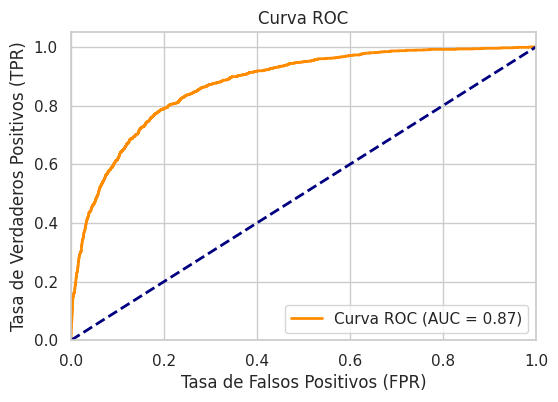

Umbral óptimo: 0.2499942566921672
FPR óptimo: 0.19223616922361692
TPR óptimo: 0.785551330798479


In [35]:
# Curva ROC

# Obtengo las probabilidades de predicción del modelo
y_probs = model.predict_proba(X_test_escalado)[:, 1]

# Calculo la ROC y el AUC
fpr, tpr, thresholds = roc_curve(y_test, y_probs, pos_label='Yes')
roc_auc = auc(fpr, tpr)

# Grafico la curva ROC
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

# Encontrar el punto óptimo (Youden's J statistic)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
optimal_fpr = fpr[optimal_idx]
optimal_tpr = tpr[optimal_idx]

print(f"Umbral óptimo: {optimal_threshold}")
print(f"FPR óptimo: {optimal_fpr}")
print(f"TPR óptimo: {optimal_tpr}")

En primer lugar, observamos a simple vista que el área bajo la curva (AUC) es 0.87, un valor considerablemente mayor a 0.5, lo que dice que se encuentra cerca de contener al punto [0, 1]. Esto es importante, ya que ese punto es el que tiene la tasa máxima de verdaderos positivos y mínima de falsos positivos.

Para encontrar el umbral óptimo, primero buscamos los TPR y FPR óptimos, que son aquellos que consiguen dar con las coordenadas del punto más cercano a [0, 1]. Lo calculamos obteniendo el mayor resultado posible de la diferencia entre TPR y FPR (maximiza TPR y minimiza FPR). Finalmente, obteniendo los índices de este punto, buscamos con qué umbral se obtuvo al calcular la curva ROC. Vemos que el umbral óptimo se encuentra en 0.24, la mitad de 0.5 que es el umbral que suelen tener por defecto los modelos de clasificación.

Para considerar si el fitting es bueno o no, es necesario pararse en una métrica. Por ser un modelo desbalanceado, descartamos la exactitud (accuracy). La precisión (precision) diría que el modelo es bueno para ambas clases, pero esto no ocurre si comparamos usando la exhaustividad (recall).

Para determinar si el modelo ajusta bien, usamos la métrica de resumen F1-Score, que vemos que es alta para la clase 'No' y muy baja para la clase 'Yes', por lo que el modelo no está consiguiendo un buen fitting.

### Estudio con datos balanceados

Para balancear el dataset usamos SMOTE.

In [36]:
# Balanceo
smote = SMOTE(random_state=42)

X_train_balanced, y_train_balanced = smote.fit_resample(X_train_escalado, y_train)

In [57]:
# Graficar Distribucion de Datos

train_data_balanced = pd.DataFrame(X_train_balanced, columns=X_train_imputado.columns)
train_data_balanced = pd.concat([train_data_balanced.drop('index', axis=1), pd.DataFrame(y_train_balanced, columns=['RainTomorrow'])], axis=1)

train_data_balanced[['Latitude','Longitude', 'RainTomorrow']]

# train_data_balanced.groupby(['Latitude', 'Longitude', 'RainTomorrow']).size().unstack().plot(kind='bar', stacked=False, figsize=(10, 6))
# plt.xlabel('Ciudad')
# plt.ylabel('Cantidad')
# plt.title('Cantidad de días lluviosos por ciudad')
# plt.legend(title='RainTomorrow')
# plt.show()

Latitude  Longitude RainTomorrow
0     -0.066749   0.000000          Yes
1      0.085450   0.622381          Yes
2     -0.091150  -0.652293           No
3     -0.091150  -0.652293           No
4     -0.091150  -0.652293           No
...         ...        ...          ...
34429  0.908850  -1.889935          Yes
34430  1.223850  -2.023692          Yes
34431 -0.325443   0.347707          Yes
34432  0.085450   0.622381          Yes
34433  1.551379  -2.162770          Yes

[34434 rows x 3 columns]

Ahora ajustamos un modelo con los datos de entrenamiento balanceados, para evaluar sus métricas y comparar con el modelo anterior.

In [60]:
# Inicializar y entrenar un modelo de regresión logística
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

model_balanced = LogisticRegression(random_state=42, max_iter=10000)
model_balanced.fit(X_train_balanced, y_train_balanced)

# Realizar predicciones en el conjunto de prueba
y_pred_balanced = model_balanced.predict(X_test_escalado)

# Calcular métricas
accuracy_balanced = accuracy_score(y_test, y_pred_balanced)

confusion_matrix_balanced = confusion_matrix(y_test, y_pred_balanced)

classification_report_balanced = classification_report(y_test, y_pred_balanced)

# Imprimir métricas
print("Métricas para logreg:")
print(f'Exactitud: {accuracy_balanced}')
print("Matriz de confusión:")
print(confusion_matrix_balanced)
print("Reporte de clasificación:")
print(classification_report_balanced)

Métricas para logreg:
Exactitud: 0.7491543528573972
Matriz de confusión:
[[3086 1216]
 [ 193 1122]]
Reporte de clasificación:
              precision    recall  f1-score   support

          No       0.94      0.72      0.81      4302
         Yes       0.48      0.85      0.61      1315

    accuracy                           0.75      5617
   macro avg       0.71      0.79      0.71      5617
weighted avg       0.83      0.75      0.77      5617



El modelo balanceado logra mejorar algunas de los indicadores respecto al caso anterior. En este caso, usar la exactitud (accuracy) para evaluar el desempeño del modelo no sería incorrecto, clasificando correctamente el 74% de los datos respecto al total.

Desde el punto de la vista de la precisión (precision), la clase 'No' muestra una mejora significativa, lo cual es esperable al ser un modelo menos sesgado. La clase 'Yes', por el contrario, tiene una peor precisión, por lo que no es garantía que los días lluviosos predichos sean correctos (casi un 50% de probabilidades).

Desde el punto de vista de la exhaustividad (recall), vemos que el balanceo hizo una diferencia, consiguiendo valores similares para ambas clases. Esta métrica empeoró para la clase 'No', pero sigue siendo moderadamente buena.

La métrica F1-Score nos muestra un valor similar al anterior para la clase 'No' y mucho mejor para la clase 'Yes'.

En términos generales, podríamos pensar que este modelo hace un mejor fitting que el anterior pero hay que tener cuidado con algo: tiene una baja precisión con la clase 'Yes', prediciendo erróneamente muchos días lluviosos que son los que más nos interesan. Sin embargo, tiene muy bajos falsos negativos para la clase 'Yes'. Teniendo en cuenta estas cosas, creemos que el modelo balanceado sigue siendo mejor que el anterior, nuevamente usando las métricas F1-Score.

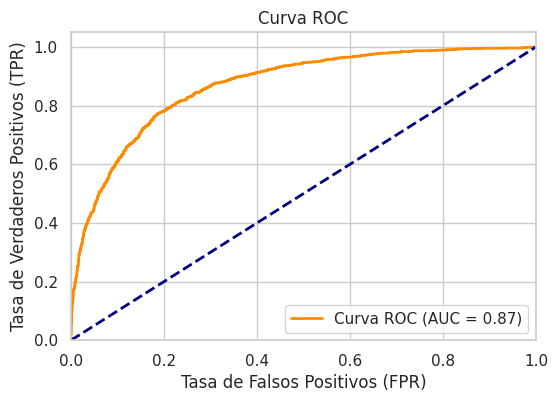

Umbral óptimo: 0.525974945870608
FPR óptimo: 0.18619246861924685
TPR óptimo: 0.7726235741444867


In [61]:
# Curva ROC

# Obtengo las probabilidades de predicción del modelo
y_probs_balanced = model_balanced.predict_proba(X_test_escalado)[:, 1]

# Calculo la ROC y el AUC
fpr, tpr, thresholds = roc_curve(y_test, y_probs_balanced, pos_label='Yes')
roc_auc = auc(fpr, tpr)

# Grafico la curva ROC
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

# Encontrar el punto óptimo (Youden's J statistic)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
optimal_fpr = fpr[optimal_idx]
optimal_tpr = tpr[optimal_idx]

print(f"Umbral óptimo: {optimal_threshold}")
print(f"FPR óptimo: {optimal_fpr}")
print(f"TPR óptimo: {optimal_tpr}")

En este caso, el área bajo la curva es muy parecido al caso anterior, sin embargo cambia mucho el valor de umbral óptimo. En este caso, se encuentra en 0.51, extremadamente cercano al que suele usarse por defecto.

## Modelo Base

Generamos ahora algunos modelos base para comparar con las métricas de los modelos anteriores. El primero de ellos se basa en clasificar a todos los datos con la clase mayoritaria, que en el dataset original y desbalanceado es 'No' (día no lluvioso).

In [62]:
# Inicializar y entrenar un modelo de regresión logística
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

warnings.filterwarnings('ignore')

# Inicializar y entrenar un modelo base usando los valores más frecuentes (en la mayoría)
df_base_model = pd.DataFrame(y_train, columns=['RainTomorrow'])

# Realizar predicciones basados en los valores más frecuentes
most_frequent = df_base_model['RainTomorrow'].mode()[0]
df_base_model['Prediction'] = most_frequent

# Calcular métricas
accuracy_base_freq = accuracy_score(df_base_model['RainTomorrow'], df_base_model['Prediction'])

confusion_matrix_base_freq = confusion_matrix(df_base_model['RainTomorrow'], df_base_model['Prediction'])

classification_report_base_freq = classification_report(df_base_model['RainTomorrow'], df_base_model['Prediction'])

# Imprimir métricas
print("Métricas para modelo base:")
print(f'Valor más frecuente: {most_frequent}')
print(f'Exactitud: {accuracy_base_freq}')
print("Matriz de confusión:")
print(confusion_matrix_base_freq)
print("Reporte de clasificación:")
print(classification_report_base_freq)

Métricas para modelo base:
Valor más frecuente: No
Exactitud: 0.7664604015492142
Matriz de confusión:
[[17217     0]
 [ 5246     0]]
Reporte de clasificación:
              precision    recall  f1-score   support

          No       0.77      1.00      0.87     17217
         Yes       0.00      0.00      0.00      5246

    accuracy                           0.77     22463
   macro avg       0.38      0.50      0.43     22463
weighted avg       0.59      0.77      0.67     22463



Como es de esperar, el desempeño de este modelo es muy pobre, fallando en predecir absolutamente todos los días lluviosos que son los más importantes. Por este motivo, todas las métricas de la case 'Yes' son cero.

Por otro lado, la precisión (precision) de la clase 'No' también baja, ya que tiene todos los falsos positivos que se originan de no clasificar correctamente aquellos datos que deberían participar a la clase 'Yes'.

A continuación, creamos un segundo modelo base que realiza una predicción basándose en si hubo lluvias o no 365 días en el pasado.

In [63]:
# Inicializar y entrenar un modelo de regresión logística
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

warnings.filterwarnings('ignore')

# Inicializar y entrenar un modelo base usando el valor de 365 días atrás
df_x_train = pd.DataFrame(X_train, columns=['Date', 'RainToday'])
df_y_train = pd.DataFrame(y_train, columns=['RainTomorrow'])
df_base_model = pd.concat([df_x_train, df_y_train], axis=1)
df_base_model['Date'] = pd.to_datetime(df['Date'])
df_base_model = df_base_model.sort_values(by='Date')

# Realizar predicciones basados en lo que ocurrió 365 días atrás
df_base_model['Prediction'] = df_base_model['RainToday'].shift(365)  # Ajusta 365 según los datos
# df_base_model = df_base_model.dropna(subset=['Prediction'])
df_base_model = df_base_model.dropna()

# Calcular métricas
accuracy_base_365_days = accuracy_score(df_base_model['RainTomorrow'], df_base_model['Prediction'])

confusion_matrix_base_365_days = confusion_matrix(df_base_model['RainTomorrow'], df_base_model['Prediction'])

classification_report_base_365_days = classification_report(df_base_model['RainTomorrow'], df_base_model['Prediction'])

# Imprimir métricas
print("Métricas para modelo base:")
print(f'Exactitud: {accuracy_base_365_days}')
print("Matriz de confusión:")
print(confusion_matrix_base_365_days)
print("Reporte de clasificación:")
print(classification_report_base_365_days)

Métricas para modelo base:
Exactitud: 0.6460959810545378
Matriz de confusión:
[[8493 2545]
 [2536  783]]
Reporte de clasificación:
              precision    recall  f1-score   support

          No       0.77      0.77      0.77     11038
         Yes       0.24      0.24      0.24      3319

    accuracy                           0.65     14357
   macro avg       0.50      0.50      0.50     14357
weighted avg       0.65      0.65      0.65     14357



Este modelo base sigue siendo bastante pobre para predecir la clase 'Yes' (días lluviosos), reflejado en sus bajas métricas de precisión (precision) y exhaustividad (recall). Se puede entender que la clase 'No' tiene métricas moderadamente altas debido a que la probabilidad de que existan días no lluviosos es mucho más alta de que los haya. A pesar de esto, hay que destacar que el hecho de que haya predecido correctamente casi el 25% de los días lluviosos quiere decir que año a año hay una buena probabilidad de que los días lluviosos coincidan entre sí.

Este modelo tiene el problema de que no es robusto a la ausencia de datos. Si un día no se registró en el dataset, no se podrá predecir 365 días a futuro.

Por último, creamos un modelo base que realiza una predicción de forma aleatoria.

In [64]:
# Inicializar y entrenar un modelo de regresión logística
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

warnings.filterwarnings('ignore')

# Inicializar y entrenar un modelo base usando valores aleatorios
df_base_model = pd.DataFrame(y_train, columns=['RainTomorrow'])

# Realizar predicciones basados en valores aleatorios
df_base_model['Prediction'] = np.random.choice(['Yes', 'No'], size=len(df_base_model))

# Calcular métricas
accuracy_base_random = accuracy_score(df_base_model['RainTomorrow'], df_base_model['Prediction'])

confusion_matrix_base_random = confusion_matrix(df_base_model['RainTomorrow'], df_base_model['Prediction'])

classification_report_base_random = classification_report(df_base_model['RainTomorrow'], df_base_model['Prediction'])

# Imprimir métricas
print("Métricas para modelo base:")
print(f'Exactitud: {accuracy_base_random}')
print("Matriz de confusión:")
print(confusion_matrix_base_random)
print("Reporte de clasificación:")
print(classification_report_base_random)

Métricas para modelo base:
Exactitud: 0.5010016471530963
Matriz de confusión:
[[8629 8588]
 [2621 2625]]
Reporte de clasificación:
              precision    recall  f1-score   support

          No       0.77      0.50      0.61     17217
         Yes       0.23      0.50      0.32      5246

    accuracy                           0.50     22463
   macro avg       0.50      0.50      0.46     22463
weighted avg       0.64      0.50      0.54     22463



Este modelo no es confiable de ninguna manera. El hecho de que acierte en su prediccón o no es completamente aleatorio y los resultados cambian en cada ejecución.